В качестве домашнего задания вам предлагается поработать над предсказанием погоды. Файл с данными вы найдете в соответствующей директории. Вам будет доступен датасет weather.csv, ПЕРВЫЕ 75% (shuffle = False) которого нужно взять для обучения, последние 25% - для тестирования.

Требуется построить 4 модели которые будут предсказывать целевую переменную <b>RainTomorrow</b> с помощью:

   1. логистической регрессии [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
   
   2. метода ближайших соседей [sklearn.neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
 
   3. Байесовского классификатора [sklearn.naive_bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
   
   4. логистической регрессии реализованной самостоятельно

Затем следует сравнить результаты моделей (по качеству и времени выполнения) и сделать вывод о том, какая модель и с какими параметрами даёт лучшие результаты.

Не забывайте о том, что работа с признаками играет очень большую роль в построении хорошей модели.

Краткое описание данных:

    Date - Дата наблюдений
    Location - Название локации, в которой расположена метеорологическая станция
    MinTemp - Минимальная температура в градусах цельсия
    MaxTemp - Максимальная температура в градусах цельсия
    Rainfall - Количество осадков, зафиксированных за день в мм
    Evaporation - Так называемое "pan evaporation" класса А (мм) за 24 часа до 9 утра
    Sunshine - Число солнечных часов за день
    WindGustDir - направление самого сильного порыва ветра за последние 24 часа
    WindGustSpeed - скорость (км / ч) самого сильного порыва ветра за последние 24 часа
    WindDir9am - направление ветра в 9 утра

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.datasets import make_classification
from sklearn import linear_model, neighbors, naive_bayes
import matplotlib.pyplot as plt
%matplotlib notebook

### Реализация логистической регрессии
__Логистическая регрессия__

$$p(y|x) = a(x, \theta) = \sigma(\langle x, \theta \rangle) = \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}$$

In [275]:
# theta = np.array([1, 2, 3])

# X =  np.array([[ 1,  1, 1],
#                [-1, -2, 1],
#                [-1, -2, 2],
#                [-2, -2, -3]
#               ])

# y = np.array([1, 1, 0, 0])

In [2]:
def probability(theta, X):
    result = np.zeros(X.shape[0])
    for i, x in enumerate(X):
        result[i] = 1 / (1 + np.exp(-np.dot(x, theta)))
    return result
# prob = probability(theta, X)


# assert type(prob) == np.ndarray, 'Возвращается неверный тип'
# assert prob.shape == (X.shape[0],), 'Неверный размер массива'
# assert (prob.round(3) == [0.998, 0.119, 0.731, 0.]).all(), 'Функция считается неверно'

Функция предсказания метки класса, получает на вход вероятности принадлежности к классу 1 и выдает метки классов $y \in \{0, 1\}$

In [3]:
def binary_class_prediction(theta, X, threshold=0.5):
    prob =  probability(theta, X)
    result = np.zeros_like(prob)
    for i, p in enumerate(prob):
        result[i] = 1 if p >= threshold else -1
    return result

# y_pred = binary_class_prediction(theta, X)


# assert type(y_pred) == np.ndarray, 'Возвращается неверный тип'
# assert y_pred.shape == (X.shape[0],), 'Неверный размер массива'
# assert min(y_pred) == 0, 'Функция считается неверно'
# assert max(y_pred) == 1, 'Функция считается неверно'

__Функционал качества логистической регрессии__

Запишем правдободовие выборки для меток класса $y \in \{+1, -1\}$ 

$$Likelihood(a, X^\ell) = \prod_{i = 1}^{\ell} a(x_i,\theta)^{[y_i = +1]} (1 - a(x_i, \theta))^{[y_i = -1]} → \operatorname*{max}_{\theta}$$ 

Прологарифмируем правдоподобие выборки и перейдем к задаче минимизации:

$$Q(a, X^\ell) =     -\sum_{i = 1}^{\ell} 
        [y_i = +1] \log a(x_i, \theta)
        +
        [y_i = -1] \log (1 - a(x_i, \theta)) \to \operatorname*{min}_{\theta}$$ 
        
Подставим $a(x, \theta)$ в функцинал качества:

$$ Q(a, X^\ell) = -\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{\exp(-\langle \theta, x_i \rangle)}{1 + \exp(-\langle \theta, x_i \rangle)}
\right)
=\\
=
-\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{1}{1 + \exp(\langle \theta, x_i \rangle)}
\right)
=\\
=
\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) $$
    

Итоговый оптимизируемый функционал качества (logloss), записанный для меток классов $y \in \{+1, -1\}$ и усредненный по выборке

$$Q(a, X^\ell) = \frac{1}{\ell}\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) \to \operatorname*{min}_{\theta}$$

Реализуем его в функции logloss:

In [4]:
def logloss1(theta, X, y):
    result = 0
#     for i, x in enumerate(y):
#         if y[i] == 0:
#             y[i] = -1
    for i, x in enumerate(X):
        result += np.log(1 + np.exp(-y[i] * np.dot(x, theta)))
    result /= X.shape[0]
    return result
# logloss(theta, X, y)

In [279]:
def logloss(theta, X, y):
    result = 0
#     for i, x in enumerate(y):
#         if y[i] == 0:
#             y[i] = -1
    for i, row in X.iterrows():
        result += np.log(1 + np.exp(-y[i] * np.dot(row.values, theta)))
    result /= X.shape[0]
    return result
# logloss(theta, X, y)

In [280]:
# assert logloss(theta, X, y).round(3) == 0.861, 'Функция считается неверно'

__Алгоритм оптимизации функционала качества. Стохастический градиентный спуск__

<b>Вход: </b> Выборка $X^\ell$, темп обучения $h$

<b>Выход: </b> оптимальный вектор весов $\theta$

1.  Инициализировать веса $\theta$
2.  Инициализировать оценку функционала качества: $Q(a, X^\ell)$
3.  <b>Повторять</b>: 

    Выбрать случайным образом подвыборку объектов $X^{batch} =\{x_1, \dots,x_n \}$ из $X^{\ell}$
    
    Рассчитать градиент функционала качества: $\nabla Q(X^{batch}, \theta)$
    
    Обновить веса: $\theta := \theta - h\cdot \nabla Q(X^{batch}, \theta)$
       
    <b>Пока</b> значение $Q$ и/или веса $\theta$ не сойдутся   

Реализуем функцию рассчета градиента функционала качества

$$\frac{\partial Q(a, X^{batch}) }{\partial \theta_j}   = \frac{\partial \frac{1}{n}\sum_{i = 1}^{n}
    \log \left(
        1 + \exp(- y_i \langle \theta, x_i \rangle)
    \right)} {\partial \theta_j}  = \frac{1}{n}\sum_{i = 1}^{n}
     \frac {1}{
        1 + \exp(- y_i \langle \theta, x_i \rangle)} \cdot  \exp(- y_i \langle \theta, x_i \rangle) \cdot -y_i x_{ij}$$

Реализуйте рассчет градиента в матричном виде:

In [5]:
def gradient1(theta, X, y):
    result = np.zeros_like(theta)
    for j, t in enumerate(theta):
        for i, x in enumerate(X):
            result[j] += np.exp(-y.iloc[i] * np.dot(x, theta)) * (-y.iloc[i] * x[j]) / (1 + np.exp(-y.iloc[i] * np.dot(x, theta)))
        result[j] /= X.shape[0]
    return result 

# assert gradient(theta, X, y).shape == theta.shape, 'Неверный размер массива'

In [282]:
def gradient(theta, X, y):
    result = np.zeros_like(theta)
    for j, t in enumerate(theta):
        for i, row in X.iterrows():
            result[j] += np.exp(-y[i] * np.dot(row.values, theta)) * (-y[i] * X.loc[i][j]) / (1 + np.exp(-y[i] * np.dot(row.values, theta)))
        result[j] /= X.shape[0]
    return result 

# assert gradient(theta, X, y).shape == theta.shape, 'Неверный размер массива'

Функция обучения уже реализована

In [6]:
def fit1(X, y, batch_size=10, h=0.05,  iters=100, plot=True):

    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)
    
    errors = []
    
    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]
    
    # plt 
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')
        
        
    for _ in range(iters):  
        
        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y.iloc[batch]

        # считаем производные
        grad = gradient1(theta, X_batch, y_batch)
        
        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'
        
        
        # Обновляем веса
        
        theta -= grad * h
        
        theta_history = np.vstack((theta_history, theta))
        
        # error
        loss = logloss1(theta, X, y)
        errors.append(loss)
        
        if plot:
            ax1.clear()            
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')
            
            
            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax2.set_xlabel('itarations')
            
            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('iterations')
            time.sleep(0.05)
            fig.canvas.draw()   
            
    return theta

In [297]:
def fit(X, y, batch_size=10, h=0.05,  iters=100, plot=True):

    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)
    
    errors = []
    
    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]
    
    # plt 
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')
        
        
    for _ in range(iters):  
        
        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X.iloc[batch]
        y_batch = y.iloc[batch]

        # считаем производные
        grad = gradient(theta, X_batch, y_batch)
        
        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'
        
        
        # Обновляем веса
        
        theta -= grad * h
        
        theta_history = np.vstack((theta_history, theta))
        
        # error
        loss = logloss(theta, X, y)
        errors.append(loss)
        
        if plot:
            ax1.clear()            
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')
            
            
            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax2.set_xlabel('itarations')
            
            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('iterations')
            time.sleep(0.05)
            fig.canvas.draw()   
            
    return theta

In [63]:
X = pd.read_csv('weather.csv')

y = X.RainTomorrow.replace({'No':-1, 'Yes': 1})

del X['RainTomorrow']
del X['Unnamed: 0']

In [64]:
X_train = X.iloc[:round(X.shape[0] * 0.75), :]

X_test = X.iloc[round(X.shape[0] * 0.75):, :]

y_train = y.iloc[:round(y.shape[0] * 0.75)]

y_test = y.iloc[round(y.shape[0] * 0.75):]

In [65]:
numeric_data = X_train.select_dtypes([np.number])

numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

In [66]:
correlations = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)


plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

In [67]:
def show_scale(features, scales):
    fig, axs = plt.subplots(figsize=(14, 10))
    sorted_weights = sorted(zip(features, scales), reverse=True)
    features = [x[0] for x in sorted_weights]
    scales = [x[1] for x in sorted_weights]
    sns.barplot(y=features, x=scales, ax=axs)
    axs.set_xlabel("Scale")
    plt.tight_layout()

<IPython.core.display.Javascript object>


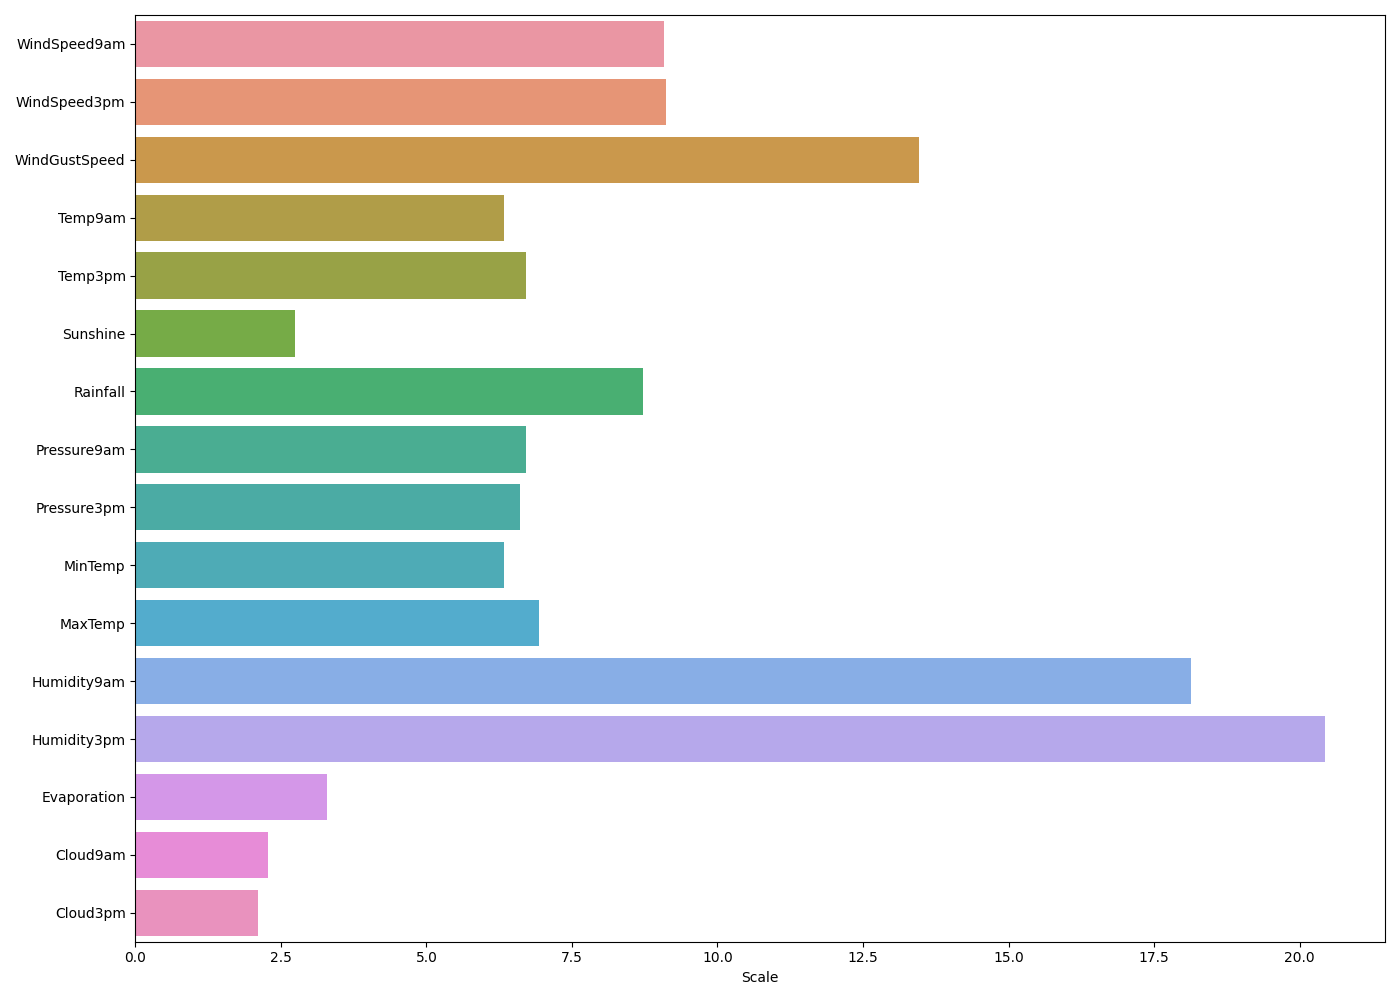

In [68]:
show_scale(numeric_features, X_train[numeric_features].std())

In [69]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

<IPython.core.display.Javascript object>


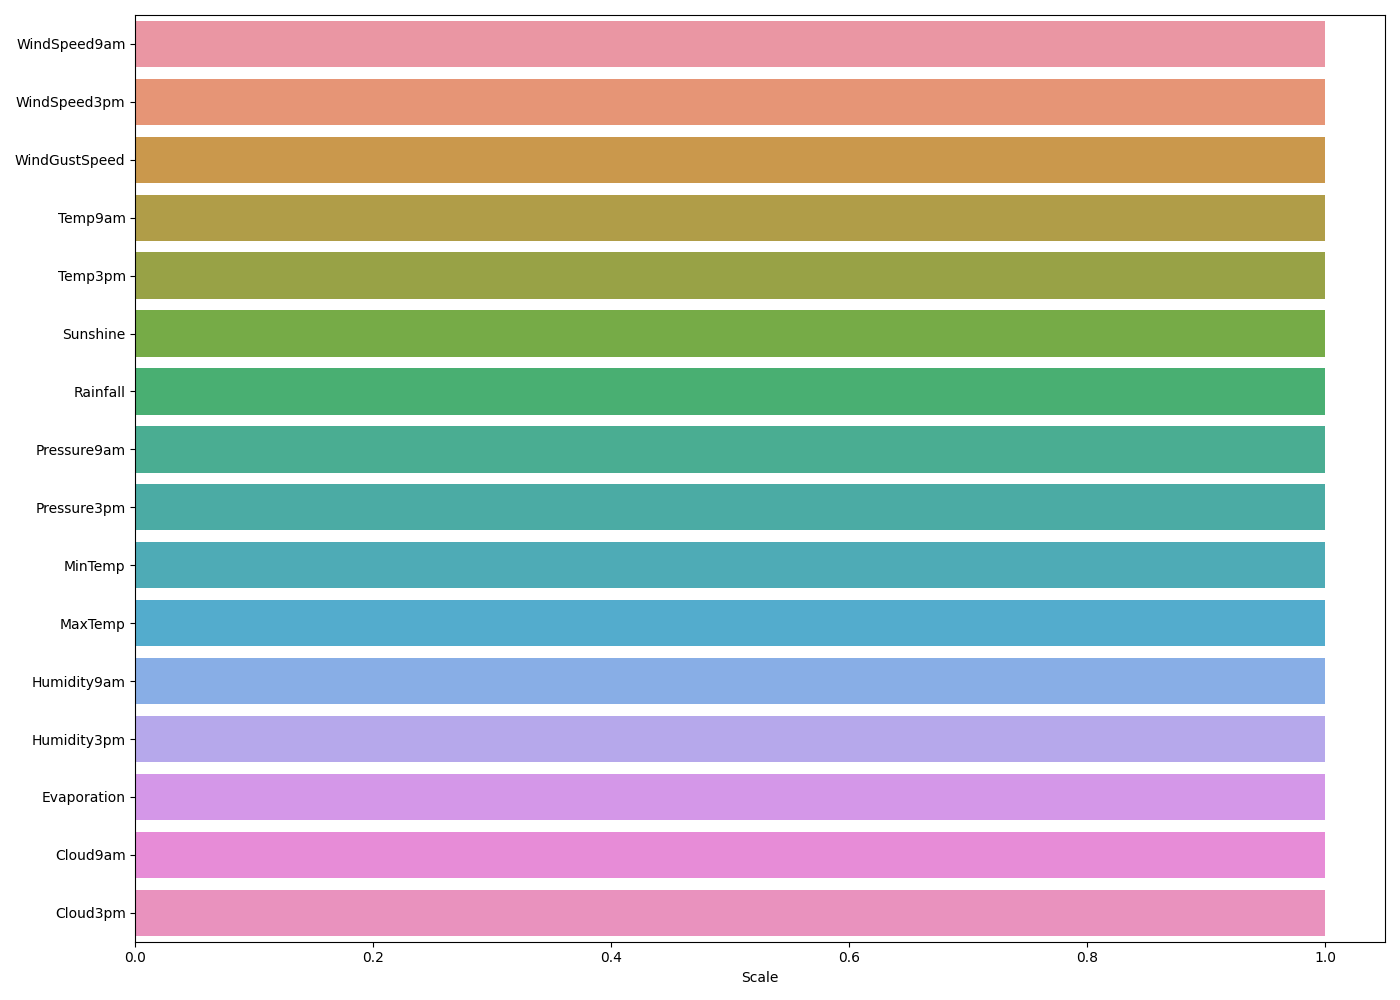

In [70]:
scales = pd.Series(data=X_train_scaled.std(axis=0), index=numeric_features)
show_scale(numeric_features, scales)

### Логистическая регрессия, реализованная самостоятельно

[0.41122151 0.27889037 0.13405702 0.68173794 0.82954133 0.82585905
 0.91617951 0.10193135 0.65670642 0.07230502 0.50995543 0.76178575
 0.53823402 0.1057252  0.36654086 0.60647966]


<IPython.core.display.Javascript object>


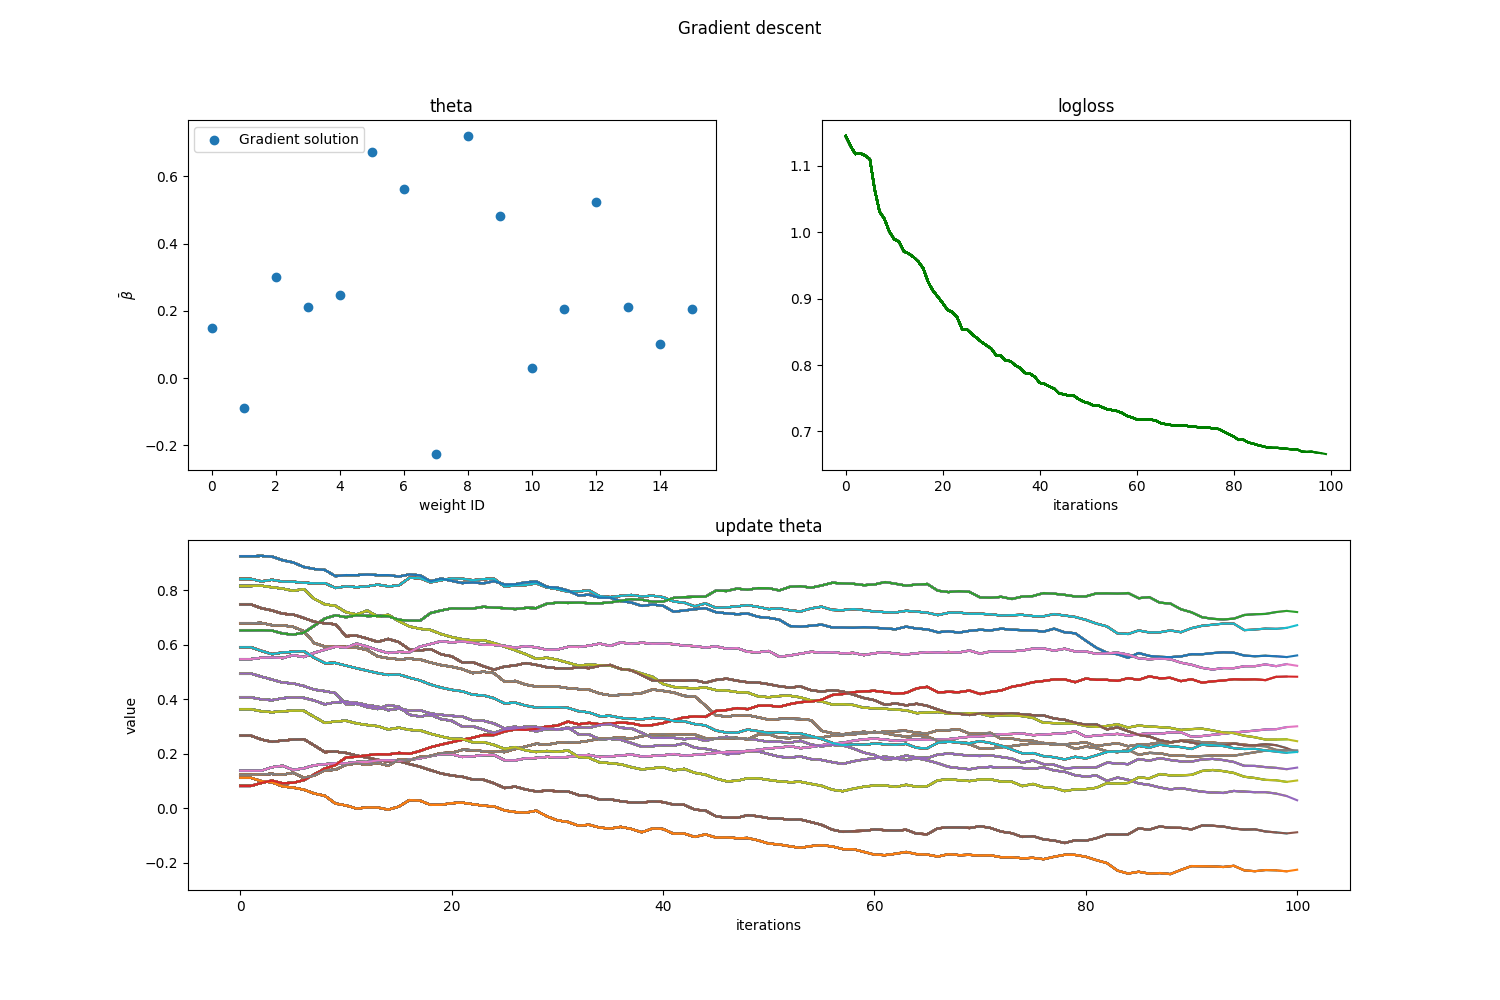

2min 36s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [295]:
%timeit -n 1 -r 1 optimal_theta = fit1(X_train_scaled, y_train)

In [305]:
%timeit -n 1 -r 1 optimal_theta = fit1(X_train_scaled, y_train, plot=False)

2min 2s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [71]:
optimal_theta = fit1(X_train_scaled, y_train, plot=False)

In [72]:
margin = np.sort(X_train_scaled.dot(optimal_theta)*y_train)
n = list(range(len(margin)))

<IPython.core.display.Javascript object>


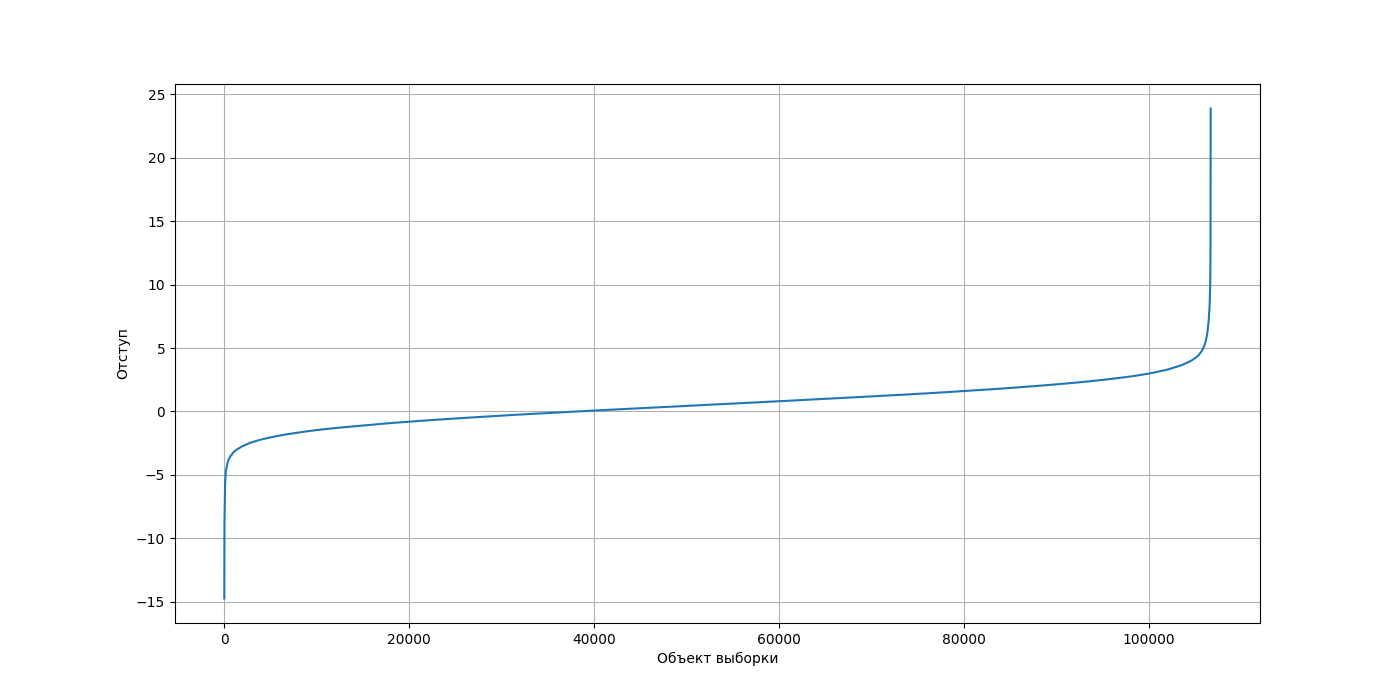

In [73]:
plt.figure(figsize=(14, 7))
plt.plot(n, margin)
ax = plt.gca()
ax.set_xlabel("Объект выборки")
ax.set_ylabel("Отступ")
ax.grid()

In [19]:
def mean_abs_error(y, y_pred):
    return y.sub(y_pred).abs().sum() / y.shape[0]

In [46]:
y_pred_1_train = binary_class_prediction(optimal_theta, X_train_scaled)
mean_abs_error(y_train, y_pred_1_train)

0.6690421491865535

In [21]:
y_pred_1_test = binary_class_prediction(optimal_theta, X_test_scaled)
mean_abs_error(y_test, y_pred_1_test)

0.543828063463486

In [37]:
def accuracy(y, y_pred):
    return (y == y_pred).sum() / y.shape[0]

In [38]:
accuracy(y_train, y_pred_1_train)

0.6654789254067233

In [39]:
accuracy(y_test, y_pred_1_test)

0.728085968268257

### LogisticRegression

In [22]:
%%timeit
logreg = linear_model.LogisticRegression().fit(X_train_scaled, y_train)
y_pred_2_train = logreg.predict(X_train_scaled)
y_pred_2_test = logreg.predict(X_test_scaled)

283 ms ± 6.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
logreg = linear_model.LogisticRegression().fit(X_train_scaled, y_train)
y_pred_2_train = logreg.predict(X_train_scaled)
y_pred_2_test = logreg.predict(X_test_scaled)

In [24]:
mean_abs_error(y_train, y_pred_2_train)

0.32335318111491396

In [25]:
mean_abs_error(y_test, y_pred_2_test)

0.3025767975694835

In [40]:
accuracy(y_train, y_pred_2_train)

0.838323409442543

In [43]:
accuracy(y_test, y_pred_2_test)

0.8487116012152582

### KNeighborsClassifier

In [329]:
%%timeit -n 1 -r 1
nearneigh = neighbors.KNeighborsClassifier()
nearneigh.fit(X_train_scaled, y_train)
y_pred_3_train = nearneigh.predict(X_train_scaled)
y_pred_3_test = nearneigh.predict(X_test_scaled)

6min 49s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [26]:
nearneigh = neighbors.KNeighborsClassifier()
nearneigh.fit(X_train_scaled, y_train)
y_pred_3_train = nearneigh.predict(X_train_scaled)
y_pred_3_test = nearneigh.predict(X_test_scaled)

In [27]:
mean_abs_error(y_train, y_pred_3_train)

0.24524356509916076

In [28]:
mean_abs_error(y_test, y_pred_3_test)

0.3352087318555193

In [41]:
accuracy(y_train, y_pred_3_train)

0.8773782174504197

In [44]:
accuracy(y_test, y_pred_3_test)

0.8323956340722404

### GaussianNB

In [29]:
%%timeit
bayes = naive_bayes.GaussianNB()
bayes.fit(X_train_scaled, y_train)
y_pred_4_train = bayes.predict(X_train_scaled)
y_pred_4_test = bayes.predict(X_test_scaled)

54.6 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
bayes = naive_bayes.GaussianNB()
bayes.fit(X_train_scaled, y_train)
y_pred_4_train = bayes.predict(X_train_scaled)
y_pred_4_test = bayes.predict(X_test_scaled)

In [31]:
mean_abs_error(y_train, y_pred_4_train)

0.383796708706456

In [32]:
mean_abs_error(y_test, y_pred_4_test)

0.3271070102396759

In [42]:
accuracy(y_train, y_pred_4_train)

0.808101645646772

In [45]:
accuracy(y_test, y_pred_4_test)

0.836446494880162

### Можно сделать вывод, что наиболее подходящим в данном случае является метод Логистической Регрессии linear_model.LogisticRegression, т.к. он дает наибольшую точность и тратит достаточно мало времени (~190 мс в нашем случае). 
### Наиболее точным является метод Ближайших Соседей, однако его реализация тратит времени даже больше, чем написанная мной Линейная Регрессия (6 мин 49 с vs 2 мин 2 с).